## Imports

In [24]:
%%capture
import numpy as np
from matplotlib import pyplot as plt
import itertools
from sklearn.utils import shuffle
import tensorflow as tf
%run "./utils.ipynb"
%run "./Data preprocessing.ipynb"

## Load Numpy Array

In [25]:
X.shape

(17615, 100, 100)

### Resize array

In [26]:
X.shape

(17615, 100, 100)

In [27]:
X = np.stack((X,)*3, axis=-1)
print(X.shape)

(17615, 100, 100, 3)


In [6]:
new_X = tf.image.resize(
    X, [224,224], method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=False,
    antialias=False, name=None
)
new_X.shape
X = np.array(new_X)

In [28]:
X.shape

(17615, 100, 100, 3)

In [29]:
type(X)

numpy.ndarray

In [32]:
from sklearn.model_selection import train_test_split
# split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state = 42, stratify=y)

## Model Building

In [33]:
from tensorflow.keras.applications import VGG16,VGG19,NASNetMobile,DenseNet201
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import Adam

In [40]:
model = tf.keras.models.Sequential()
base_model = tf.keras.applications.ResNet101V2(
    include_top=False, weights='imagenet',
    pooling='max'
)
model.add(tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"))
# base_model.trainable = False
model.add(base_model)
model.add(BatchNormalization())
model.add(Dense(2048, activation='relu', kernel_regularizer=l1_l2(0.01)))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

train_layers = [layer for layer in base_model.layers[::-1][:5]]

for layer in base_model.layers:
  if layer in train_layers:
    layer.trainable = True


model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['accuracy'])

In [37]:
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or calling `fit()` with some data, or specify an `input_shape` argument in the first layer(s) for automatic build.

In [41]:
# Using early stopping and reduce lr on plateau to control the performance
cb_1 = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-5, verbose=0) 
cb_2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=3, verbose=1, mode='auto', restore_best_weights=True)

cbs = [cb_1, cb_2 ]

In [42]:
history = model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=8, callbacks=cbs,verbose=1)

Epoch 1/8
413/413 [==============================] - 803s 2s/step - loss: 517.4826 - accuracy: 0.6516 - val_loss: 19.2682 - val_accuracy: 0.7716
Epoch 2/8
413/413 [==============================] - 874s 2s/step - loss: 9.2186 - accuracy: 0.8117 - val_loss: 6.2128 - val_accuracy: 0.6013
Epoch 3/8
413/413 [==============================] - 793s 2s/step - loss: 3.2074 - accuracy: 0.8723 - val_loss: 7.7173 - val_accuracy: 0.2916
Epoch 4/8
413/413 [==============================] - 802s 2s/step - loss: 2.0891 - accuracy: 0.9274 - val_loss: 0.8425 - val_accuracy: 0.8726
Epoch 5/8
413/413 [==============================] - 1305s 3s/step - loss: 0.6147 - accuracy: 0.9649 - val_loss: 9.0696 - val_accuracy: 0.2109
Epoch 6/8
413/413 [==============================] - 1503s 4s/ste

In [51]:
history = history + model.fit(X_train, y_train,validation_data=(X_test, y_test), epochs=8, callbacks=cbs,verbose=1)

Epoch 1/8
122/413 [=======>......................] - ETA: 16:14 - loss: 0.1687 - accuracy: 0.9954

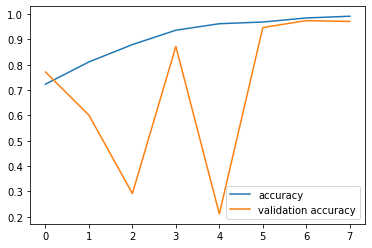

In [47]:
accuracy_graph(history)

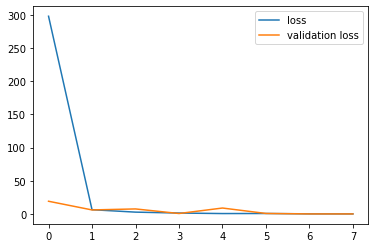

In [44]:
loss_graph(history)

In [48]:
predictions = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(y_test, predictions)

Confusion matrix, without normalization
[[891   0   0   4   9]
 [  0 798  77   0   0]
 [  0  13 862   0   0]
 [ 11   1   0 859   4]
 [  7   0   0   1 867]]


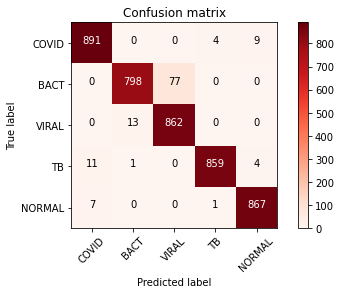

In [49]:
plot_confusion_matrix(cm, ["COVID" ,"BACT", "VIRAL", "TB", "NORMAL"])

In [50]:

print(classification_report(y_test, predictions));

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       904
           1       0.98      0.91      0.95       875
           2       0.92      0.99      0.95       875
           3       0.99      0.98      0.99       875
           4       0.99      0.99      0.99       875

    accuracy                           0.97      4404
   macro avg       0.97      0.97      0.97      4404
weighted avg       0.97      0.97      0.97      4404

